## Figure S5C

## Helper codes: run below cells before any of the other cells. 

In [1]:
import mat73
import h5py
import hdf5storage as st
# from pymatreader import read_mat
import pickle
import os

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
from scipy.stats import wilcoxon, norm, kruskal, tukey_hsd, mannwhitneyu, sem
from scipy.optimize import curve_fit
from scipy.io import loadmat
from scipy.linalg import null_space
from scipy.spatial.distance import cdist
import seaborn as sns
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
import math
from itertools import combinations, product

from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

from umap import UMAP

# from libsvm import svmutil

# import torch
# import torch.nn as nn
# import torch.optim as optim

# from pycaret.classification import *

c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading variables

# ABO Neuropixels
with open('resp_matrix_ep_RS_all_32sess_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_RS_all = pickle.load(f)

    list_rate_RS = resp_matrix_ep_RS_all['list_rate_RS'].copy()
    list_rate_RS_dr = resp_matrix_ep_RS_all['list_rate_RS_dr'].copy()
    list_rate_all = resp_matrix_ep_RS_all['list_rate_all'].copy()
    list_rate_all_dr = resp_matrix_ep_RS_all['list_rate_all_dr'].copy()
    list_slopes_RS_an_loglog = resp_matrix_ep_RS_all['list_slopes_RS_an_loglog'].copy()
    list_slopes_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_all_an_loglog'].copy()

    sess_inds_qual_all = resp_matrix_ep_RS_all['sess_inds_qual_all'].copy()

In [3]:
def compute_mean_var_trial(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1)
        trial_var = np.var(trial_rate, axis=1, ddof=1)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = pd.concat([trial_mean] * label_cnt_dict[trial_type], axis=1)
        list_trial_var[trial_ind] = pd.concat([trial_var] * label_cnt_dict[trial_type], axis=1)

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [4]:
def compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1, dtype=np.longdouble)
        trial_var = np.var(trial_rate, axis=1, ddof=1, dtype=np.longdouble)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = trial_mean.copy()
        list_trial_var[trial_ind] = trial_var.copy()

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [5]:
def annotate_lineplot_significance(significant_values, axes, ax_ind, line_height_ratio, color):

    if len(significant_values) > 0:

        # Initialize start and end points of lines
        start = None
        lines = []
        dots = []

        # Loop through sorted significant_values to group them into lines or dots
        for i in range(len(significant_values) - 1):
            if start is None:
                start = significant_values[i]

            # Check if the next value is part of the same line
            if significant_values[i + 1] - significant_values[i] > 0.1 + 1e-9:  # Threshold for a gap; add pseudo-value to avoid floating point issue
                if start == significant_values[i]:
                    dots.append(start)  # Isolated point
                else:
                    lines.append((start, significant_values[i]))  # Line segment
                start = None

        # Check the last value
        if start is None:
            dots.append(significant_values[-1])
        else:
            lines.append((start, significant_values[-1]))

        # Plot lines and dots
        for line in lines:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)  # Draw a line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
                
        for dot in dots:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)  # Draw a very short line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)

In [6]:
# # Collect filling box count for each slope

# list_target_slopes = np.linspace(-1, 2, 31, endpoint=True)
# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32
# num_box_sizes = 1

# list_box_ratios_RRneuron2 = np.zeros((len(list_target_slopes), num_sess, num_box_sizes))
# list_box_ratios_RRneuron2_isomap = np.zeros((len(list_target_slopes), num_sess, num_box_sizes))
# for slope_ind, target_slope in enumerate(list_target_slopes):
#     file_name = 'filling_boxcount_ABO_' + str(slope_ind) + '.pickle'
    
#     with open(file_name, 'rb') as f:
#         filling_boxcount_ABO = pickle.load(f)
#         if slope_ind == 0:
#             list_box_ratios_asis = filling_boxcount_ABO['list_box_ratios_asis'].copy()
#             list_box_ratios_asis_isomap = filling_boxcount_ABO['list_box_ratios_asis_isomap'].copy()   
   
#         list_box_ratios_RRneuron2[slope_ind] = filling_boxcount_ABO['list_box_ratios_RRneuron'].copy()
#         list_box_ratios_RRneuron2_isomap[slope_ind] = filling_boxcount_ABO['list_box_ratios_RRneuron_isomap'].copy()

# save_file_name = 'box_ratio_ABO.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_box_ratios_asis', 'list_box_ratios_RRneuron2', 'list_box_ratios_asis_isomap', 'list_box_ratios_RRneuron2_isomap'],
#                     'list_box_ratios_asis': list_box_ratios_asis, 'list_box_ratios_RRneuron2': list_box_ratios_RRneuron2,
#                     'list_box_ratios_asis_isomap': list_box_ratios_asis_isomap, 'list_box_ratios_RRneuron2_isomap': list_box_ratios_RRneuron2_isomap}, f)

## Codes for figures

## Figure S5C

significant slope: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9
 2. ]


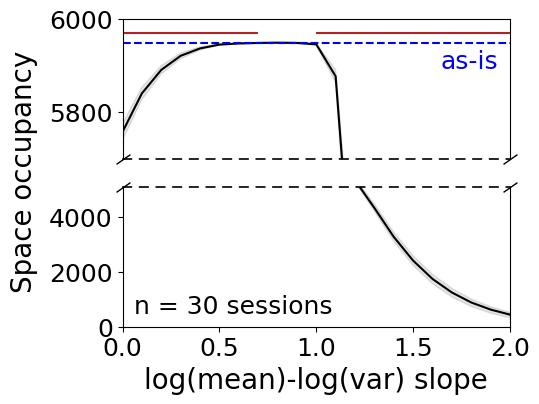

In [ ]:
save_file_name = 'box_ratio_ABO.pickle' # box size 1
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    box_ratio_ABO = pickle.load(f)

    list_box_ratios_asis = box_ratio_ABO['list_box_ratios_asis'].copy()
    list_box_ratios_RRneuron2 = box_ratio_ABO['list_box_ratios_RRneuron2'].copy()

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)
list_box_ratios_RRneuron2 = list_box_ratios_RRneuron2[10:]

num_sess = 32

# Squeeze when num_box_sizes = 1
list_box_ratios_asis = np.squeeze(list_box_ratios_asis)
list_box_ratios_RRneuron2 = np.squeeze(list_box_ratios_RRneuron2)

# Exclude low quality sessions (0, 6)
list_box_ratios_asis = np.concatenate([list_box_ratios_asis[1:6], list_box_ratios_asis[7:]], axis=0)
list_box_ratios_RRneuron2 = np.concatenate([list_box_ratios_RRneuron2[:, 1:6], list_box_ratios_RRneuron2[:, 7:]], axis=1)
num_sess = list_box_ratios_asis.shape[0]

# Wilcoxon signed-rank test
list_pvals_box_ratios = np.zeros(len(list_target_slopes))
for slope_ind, target_slope in enumerate(list_target_slopes):
    list_pvals_box_ratios[slope_ind] = list(wilcoxon(list_box_ratios_asis,
                                                     list_box_ratios_RRneuron2[slope_ind]))[1]
list_pvals_box_ratios = np.array(multipletests(list_pvals_box_ratios, method='holm')[1]) # multiple comparisons correction
list_sig_slopes_boxratio = list_target_slopes[list_pvals_box_ratios < 0.05].copy()
print(f'significant slope: {list_sig_slopes_boxratio}')

# line plot

# fig, axes = plt.subplots(1, 1, figsize=(5, 4))
fig, axes = plt.subplots(2, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

list_means_boxratio = np.nanmean(list_box_ratios_RRneuron2, axis=1)
list_errs_boxratio = sem(list_box_ratios_RRneuron2, axis=1, nan_policy='omit')

for ax in axes:
    ax.plot(list_target_slopes, list_means_boxratio, color='k')
    ax.fill_between(list_target_slopes, list_means_boxratio-list_errs_boxratio, \
                            list_means_boxratio+list_errs_boxratio, color='k', alpha=0.1)

axes[0].set_ylim(5700, 6000) # box size 1
axes[1].set_ylim(0, 5100) # box size 1

axes[0].spines['bottom'].set_linestyle((0, (5, 5))) 
axes[1].spines['top'].set_linestyle((0, (5, 5)))
axes[0].spines['bottom'].set_linewidth(1.2)
axes[1].spines['top'].set_linewidth(1.2)

axes[1].set_xlabel('log(mean)-log(var) slope', fontsize=20)
# axes[0].set_ylabel('Space occupancy', fontsize=20)
fig.text(-0.1, 0.5, "Space occupancy", va='center', rotation='vertical', fontsize=20)
axes[0].tick_params('both', labelsize=18)
axes[1].tick_params('both', labelsize=18)
axes[0].set_xticks([])
axes[1].set_yticks(np.arange(0, 5000, 2000))
# axes[0].set_yscale('log')

d = 0.7 # how big to make the diagonal lines in axes coordinates
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=10, linestyle="none", color='k', clip_on=False)
axes[0].plot([0, 1], [0, 0], transform=axes[0].transAxes, **kwargs)
axes[1].plot([0, 1], [1, 1], transform=axes[1].transAxes, **kwargs)

height = (np.nanmean(list_box_ratios_asis)-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.82, height-0.18), xycoords='axes fraction', fontsize=18, color='blue')
axes[1].annotate(f'n = {num_sess} sessions', xy=(0.03, 0.1), xycoords='axes fraction', fontsize=18, color='k')

axes[0].set_xlim(0, 2)
axes[1].set_xlim(0, 2)

# significance
annotate_lineplot_significance(list_sig_slopes_boxratio, axes=axes, ax_ind=0, line_height_ratio=0.9, color='firebrick')
axes[0].axhline(np.nanmean(list_box_ratios_asis), linestyle='--', c='blue')

plt.show()